<a href="https://colab.research.google.com/github/krisadas/finrl-multiple/blob/main/FinRLManystock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%bash
ls
cd 'drive/MyDrive/Colab Notebooks/FinRLMultiStock'
echo '#################'
echo '# My Drive'
ls

drive
sample_data
#################
# My Drive
datasets
results
tensorboard_log
trained_models


In [3]:
# Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-v2p_inzy
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-v2p_inzy
     |████████████████████████████████| 153kB 12.5MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-fdllxjmf/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-fdllxjmf/pyfolio
     |████████████████████████████████| 6.3MB 44.4MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=38749 sha256=f74fd7292f706d14b10c496edbe146fbf69cf39ea38341394958a0cdabf23eb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-0lu_slw1/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=98a399364d0c1dbdbab7c6ef8aec52be2195e7e6b9043c7dbec406f409d6f744


In [4]:
import os
import pathlib
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

     |████████████████████████████████| 245kB 9.4MB/s 
     |████████████████████████████████| 1.4MB 15.2MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065191 sha256=69bae7377d92a71f690cdee2a96f584d83d90ec6b6d80aa5f71a6e1581dc3081
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 110.5MB 95kB/s 
     |████████████████████████████████| 512kB 54.1MB/s 
     |████████████████████████████████| 20.1MB 56.2MB/s 
     |████████████████████████████████| 3.8MB 56.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=e044fcf2dfd6a6be609262f3cc7241cb5b479cdecc3682b646018d76cbdcd3db
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.use('Agg')
import datetime
import os
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot
import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
!pip install pyfolio

In [ ]:
PATH_TO_MODEL_DIR = 'drive/MyDrive/Colab Notebooks/FinRLMultiStock/'
print(PATH_TO_MODEL_DIR)

import os
if not os.path.exists(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.TENSORBOARD_LOG_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.TENSORBOARD_LOG_DIR)
if not os.path.exists(PATH_TO_MODEL_DIR + config.RESULTS_DIR):
    os.makedirs(PATH_TO_MODEL_DIR + config.RESULTS_DIR)

drive/MyDrive/Colab Notebooks/FinRLMultiStock/


In [ ]:
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP']#,
                 #'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ', 
                  #'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']
set_ticker=['PTT.BK','HANA.BK','IVL.BK','KBANK.BK','KKP.BK','KTB.BK','LH.BK',
           'INTUCH.BK','AP.BK','BCP.BK','GUNKUL.BK',
           'MAJOR.BK','MBK.BK','ORI.BK','PTTEP.BK','PTTGC.BK',
           'QH.BK','SCB.BK','SCC.BK','TASCO.BK', 'TCAP.BK', 'THANI.BK', 'TISCO.BK']#,
           # 'TOP.BK', 'TPIPP.BK', 'TTW.BK', 'TVO.BK', 'WHAUP.BK']
data_df = YahooDownloader(start_date = '2015-01-01',
                          end_date = '2021-01-01',
                          ticker_list = set_ticker).fetch_data()
#data_df= data_df.fillna(0)
data_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2015-01-05,6.050000,6.050000,5.950000,4.386985,8554100.0,AP.BK,0
1,2015-01-05,31.250000,31.750000,30.750000,23.844332,3235900.0,BCP.BK,0
2,2015-01-05,3.964284,4.071427,3.964284,3.529611,8425902.0,GUNKUL.BK,0
3,2015-01-05,37.500000,38.000000,37.250000,27.558842,587600.0,HANA.BK,0
4,2015-01-05,78.750000,79.000000,77.750000,55.169353,6333100.0,INTUCH.BK,0


In [ ]:
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
## you can add more technical indicators
## visit https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

data_df = fe.preprocess_data(data_df)
data_df.head()

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']
Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2015-01-05,6.050000,6.050000,5.950000,4.386985,8554100.0,AP.BK,0,0.0,4.420688,4.316417,0.0,-66.666667,100.0,4.386985,4.386985,-487.669674,6.050000,4.386985,1.0,1663.009022,0.0,-0.133551
1462,2015-01-05,31.250000,31.750000,30.750000,23.844332,3235900.0,BCP.BK,0,0.0,4.420688,4.316417,0.0,-66.666667,100.0,23.844332,23.844332,-196.855609,31.250000,23.844332,0.0,790.566826,0.0,-0.133551
2924,2015-01-05,3.964284,4.071427,3.964284,3.529611,8425902.0,GUNKUL.BK,0,0.0,4.420688,4.316417,0.0,-66.666667,100.0,3.529611,3.529611,-101.898203,3.964284,3.529611,1.0,505.694608,0.0,-0.133551
4386,2015-01-05,37.500000,38.000000,37.250000,27.558842,587600.0,HANA.BK,0,0.0,4.420688,4.316417,0.0,-66.666667,100.0,27.558842,27.558842,-397.384813,37.500000,27.558842,0.0,1392.154439,0.0,-0.133551
5848,2015-01-05,78.750000,79.000000,77.750000,55.169353,6333100.0,INTUCH.BK,0,0.0,4.420688,4.316417,0.0,-66.666667,100.0,55.169353,55.169353,-568.817240,78.750000,55.169353,0.0,1906.451721,0.0,-0.133551


In [ ]:
df = data_df
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
df.head()        

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,cov_list
0,2016-01-14,5.650000,5.70000,5.550000,4.245367,7379800.0,AP.BK,3,-0.000826,4.356226,4.038890,47.975169,89.536258,25.758712,4.195646,4.364568,-235.448624,5.625000,4.197558,5.0,334.363125,-0.058900,0.000330,"[[0.00023962826965546536, 4.4743165215848464e-..."
1,2016-01-14,33.500000,33.50000,32.750000,26.279589,2454200.0,BCP.BK,3,-0.185661,27.768593,25.507300,45.370310,-46.414176,0.330821,26.750762,27.726293,-266.221484,33.750000,26.637947,0.0,411.020565,-0.895895,-0.104703,"[[0.00023962826965546536, 4.4743165215848464e-..."
2,2016-01-14,4.107141,4.30357,4.071427,3.784712,71475620.0,GUNKUL.BK,3,0.032155,3.796293,3.023757,55.887354,99.470738,9.279757,3.480147,3.642512,-3.487745,4.133927,3.410025,5.0,85.458942,-0.066220,-0.003204,"[[0.00023962826965546536, 4.4743165215848464e-..."
3,2016-01-14,33.000000,33.75000,33.000000,25.427324,586200.0,HANA.BK,3,-0.339149,27.437063,24.823790,47.457821,-89.122431,0.037994,26.884900,26.734183,-235.377518,33.625000,26.130427,0.0,344.089190,-0.850146,-0.213599,"[[0.00023962826965546536, 4.4743165215848464e-..."
4,2016-01-14,50.750000,51.25000,50.250000,37.882076,11461900.0,INTUCH.BK,3,-2.777723,47.329572,31.997745,36.035748,-62.089787,40.411311,42.914265,48.705971,-75.717315,51.375000,39.663659,0.0,175.633414,-9.643051,-1.122300,"[[0.00023962826965546536, 4.4743165215848464e-..."


In [ ]:
train = data_split(df, start = '2015-01-01', end = '2019-01-01')
trade = data_split(df, start = '2019-01-01', end = '2021-01-01')
train.to_csv(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR + '/train_MULTI.csv',index=False)
trade.to_csv(PATH_TO_MODEL_DIR + config.DATA_SAVE_DIR + '/trade_MULTI.csv',index=False)


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
#state_space = 156
print(f"Stock data Dimensions: {stock_dimension}, State Spaces: {state_space}")
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    #"transaction_cost_pct": 0.001, 
    "buy_cost_pct":0.001,
    "sell_cost_pct":0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock data Dimensions: 23, State Spaces: 231
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

In [ ]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=100000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device
Logging to tensorboard_log/a2c/a2c_8
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -32.7    |
|    explained_variance | 0.194    |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | -12.2    |
|    std                | 1        |
|    value_loss         | 0.565    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.16e+06 |
|    total_cost         | 5.37e+04 |
|    total_reward       | 1.63e+05 |
|    total_reward_pct   | 16.3     |
|    total_trades       | 15789    |
| time/                 |          |
|    fps                | 221      

In [ ]:
trained_a2c.save(PATH_TO_MODEL_DIR + config.TRAINED_MODEL_DIR+'/trained_a2c.model')

In [ ]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,cov_list
0,2019-01-02,6.05,6.100000,5.900000,5.276706,6914100.0,AP.BK,2,-0.300735,6.094872,4.946962,32.405759,-97.526460,40.942925,5.705529,6.443250,-99.247355,6.025000,5.520917,5.0,187.215676,-0.946318,-0.790860,"[[0.00026410531019031727, 4.7678448654249535e-..."
0,2019-01-02,31.75,32.250000,31.500000,29.620634,1936200.0,BCP.BK,2,-0.426022,32.910347,28.869832,40.178938,-89.289337,33.162550,30.866581,31.027222,-97.093195,31.750000,30.890089,0.0,230.349274,-0.860408,-0.191130,"[[0.00026410531019031727, 4.7678448654249535e-..."
0,2019-01-02,2.35,2.383333,2.316666,2.240490,12944400.0,GUNKUL.BK,2,-0.077455,2.720437,2.072950,42.638659,-115.986529,22.223655,2.417731,2.464276,-22.062135,2.316666,2.396693,5.0,110.470390,-0.186182,-0.489430,"[[0.00026410531019031727, 4.7678448654249535e-..."
0,2019-01-02,32.50,33.000000,32.000000,28.949314,1171800.0,HANA.BK,2,-0.735143,33.838458,27.633601,43.280272,-103.335674,15.480006,30.766185,31.772196,-78.453091,32.125000,30.736030,0.0,192.752214,-1.822902,-0.324396,"[[0.00026410531019031727, 4.7678448654249535e-..."
0,2019-01-02,48.00,48.250000,47.500000,43.209175,4088900.0,INTUCH.BK,2,-0.691450,45.040996,40.974367,42.990038,-36.536002,15.628182,43.597237,45.175603,-142.267240,47.500000,43.007681,0.0,224.036662,-2.395536,-0.282998,"[[0.00026410531019031727, 4.7678448654249535e-..."


In [ ]:
#trade = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value)
#print(df_actions)
df_actions.head()

           date  account_value
0    2019-01-02   1.000000e+06
1    2019-01-03   9.999319e+05
2    2019-01-04   1.000786e+06
3    2019-01-07   1.001690e+06
4    2019-01-08   1.001247e+06
..          ...            ...
482  2020-12-24   8.341644e+05
483  2020-12-25   8.421036e+05
484  2020-12-28   8.286214e+05
485  2020-12-29   8.411807e+05
486  2020-12-30   8.288011e+05

[487 rows x 2 columns]


,AP.BK,BCP.BK,GUNKUL.BK,HANA.BK,INTUCH.BK,IVL.BK,KBANK.BK,KKP.BK,KTB.BK,LH.BK,MAJOR.BK,MBK.BK,ORI.BK,PTT.BK,PTTEP.BK,PTTGC.BK,QH.BK,SCB.BK,SCC.BK,TASCO.BK,TCAP.BK,THANI.BK,TISCO.BK
date,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0,29,0,0,0,39,100,67,0,0,0,0,0,0,61,71,100,0,11,0,0,100,75
2019-01-03,0,29,0,0,0,-37,100,-67,100,0,55,0,0,0,100,-13,100,0,48,0,0,100,-48
2019-01-04,0,-58,0,0,70,-2,30,0,100,81,64,0,0,0,-100,56,100,0,-36,0,0,100,-27
2019-01-07,95,100,100,0,4,0,77,0,100,-81,76,96,42,0,49,100,100,42,-23,0,100,100,0
2019-01-08,100,-100,100,0,-74,1,-3,100,100,0,45,37,87,0,68,-100,100,-42,52,0,37,100,94


In [ ]:
from finrl.trade.backtest import backtest_stats, backtest_plot
print("==============Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Results===========
Annual return         -0.092594
Cumulative returns    -0.171199
Annual volatility      0.236704
Sharpe ratio          -0.291781
Calmar ratio          -0.209664
Stability              0.718567
Max drawdown          -0.441628
Omega ratio            0.941197
Sortino ratio         -0.384824
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.011809
Daily value at risk   -0.030096
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (487, 8)


Start date,2019-01-02
End date,2020-12-30
Total months,23
,Backtest
Annual return,-9.259%
Cumulative returns,-17.12%
Annual volatility,23.67%
Sharpe ratio,-0.29
Calmar ratio,-0.21
Stability,0.72
Max drawdown,-44.163%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.16,2019-04-02,2020-03-16,NaT,NaN
1,2.38,2019-02-25,2019-03-06,2019-03-22,20
2,1.28,2019-02-06,2019-02-15,2019-02-20,11
3,0.85,2019-03-22,2019-03-29,2019-04-01,7
4,0.31,2019-01-07,2019-01-14,2019-01-21,11


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


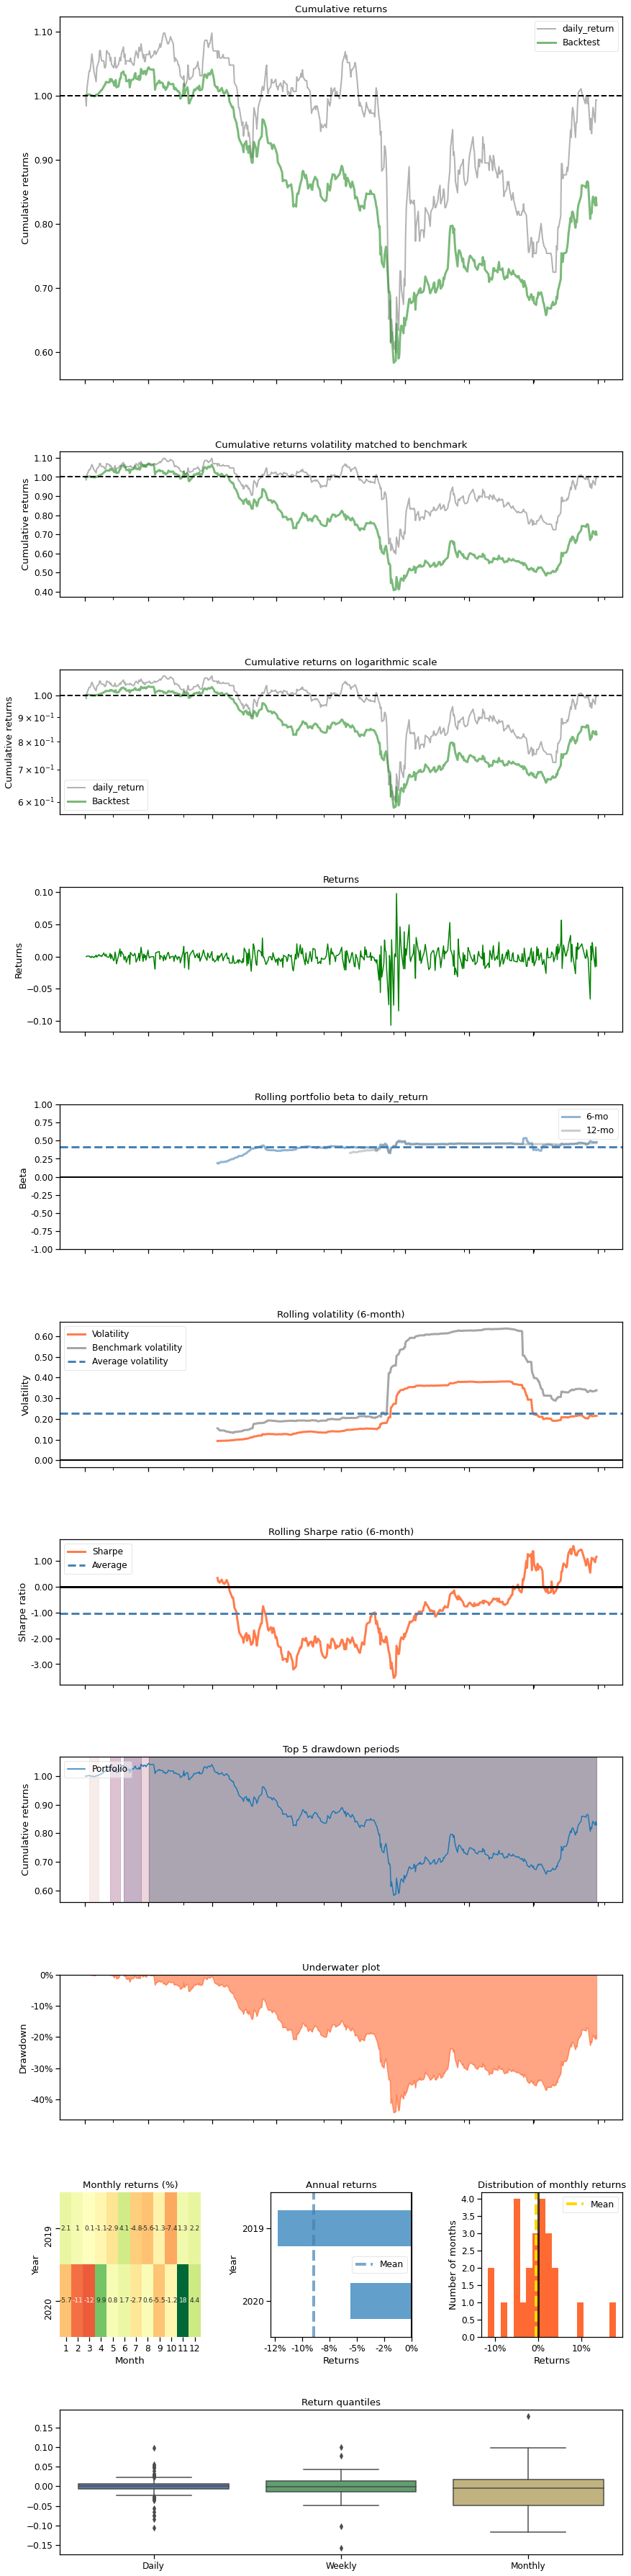

In [ ]:
%matplotlib inline
backtest_plot(account_value=df_account_value, baseline_ticker = 'PTT.BK',
             baseline_start = '2019-01-01', baseline_end = '2021-01-01')